In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd

In [2]:
raw_dat = pd.read_excel("../data/raw_data.xlsx")
raw_dat['Normalized'] = (raw_dat['mkt_r'] - raw_dat['dep_f_r'])/(raw_dat['len_f_r'] - raw_dat['dep_f_r'])
dat = raw_dat.drop(columns=['mkt_r', 'dep_f_r', 'len_f_r'])
dat.to_csv("../data/reserve_demand_cruve_data.csv", index=False)

# Non-Parametric Modeling

In [3]:
import reserves_demand.curve_nparam_fit as npcf

In [18]:
import imp; imp.reload(npcf)
obj = npcf.CurveNonParamFit(
    data = dat, 
    dep_var = 'Normalized',
    main_indep_var= 'excess_reserve',
    dep_var_name= 'Normalized Overnight Rate',                 
    main_indep_var_name= 'Excess Reserve',
    nFolds=5,
)

Running cross-validation for GAM Splines model
Best parameters for GAM Splines: {'lam': 0.001, 'model_type': 'linear', 'n_splines': 20}
Training Metrics: RMSE         0.054297
MAE          0.035681
MAPE        23.163793
R2           0.929567
MSLE         0.001927
MedianAE     0.018503
dtype: float64
Validation Metrics: RMSE         0.059439
MAE          0.037665
MAPE        27.829436
R2           0.916755
MSLE         0.002391
MedianAE     0.016255
dtype: float64


Running cross-validation for Random Forest model
Best parameters for Random Forest: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training Metrics: RMSE        0.017607
MAE         0.011441
MAPE        6.455826
R2          0.992594
MSLE        0.000190
MedianAE    0.006411
dtype: float64
Validation Metrics: RMSE         0.048457
MAE          0.031612
MAPE        20.930702
R2           0.944674
MSLE         0.001547
MedianAE     0.013021
dtype: float64


Best model based on Validation R

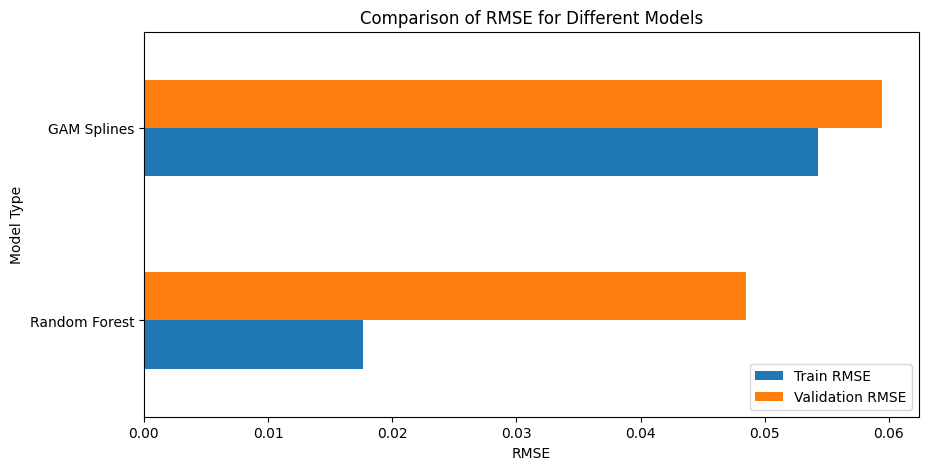

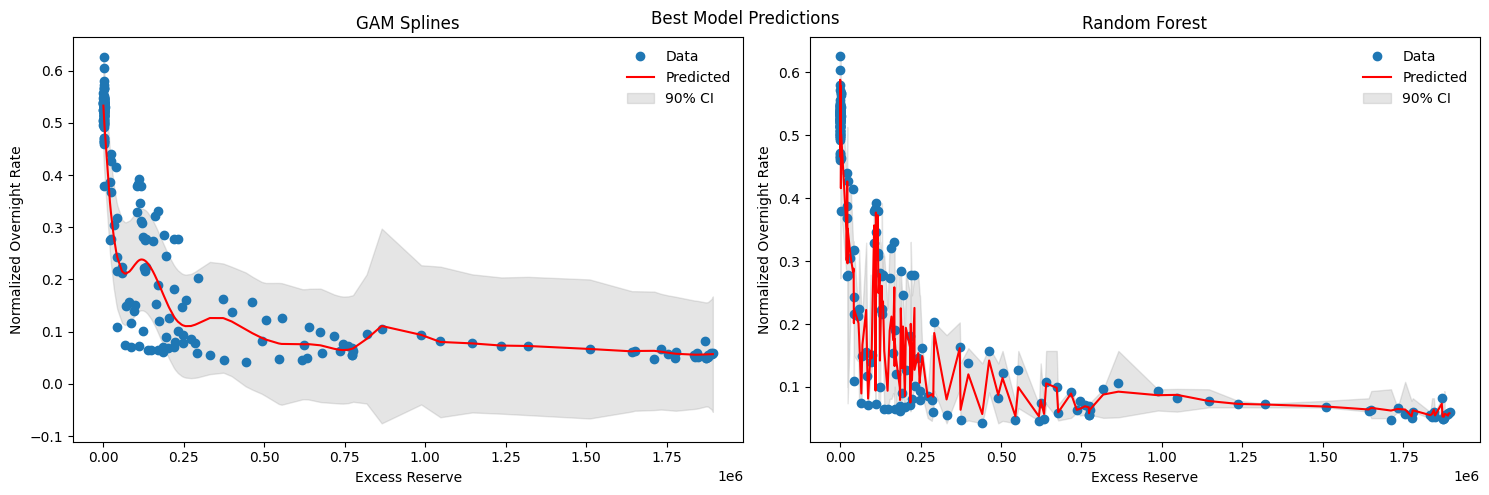

In [19]:
best_model_type, comparison_result  = obj.compare_models(verbose = True, plot=True)
comparison_result.set_index('Model Type').T
obj.plot_best()

In [6]:
forecast_input = dat.tail(2).drop(columns=['Normalized'])
forecast_output = obj.predict_best('Best Model', X=forecast_input)
forecast_output

,excess_reserve,ovn_vol,vix,acnusd,hicp,ypred
228,0.927237,0.031745,0.468667,1.504435,3.387595,0.064152
229,0.903961,0.042783,0.414104,1.495997,3.391160,0.062520


# Parametric Modeling

In [7]:
import reserves_demand.curve_param_fit as pcf
obj = pcf.CurveParamFit(
    data = dat, 
    dep_var = 'Normalized',
    main_indep_var= 'excess_reserve',
    dep_var_name= 'Normalized Overnight Rate',                 
    main_indep_var_name= 'Excess Reserve',
    constant = True,
    Q = 0.9,
    nFolds=5,
    parallel=True,
    search_method = 'all_combinations'
)

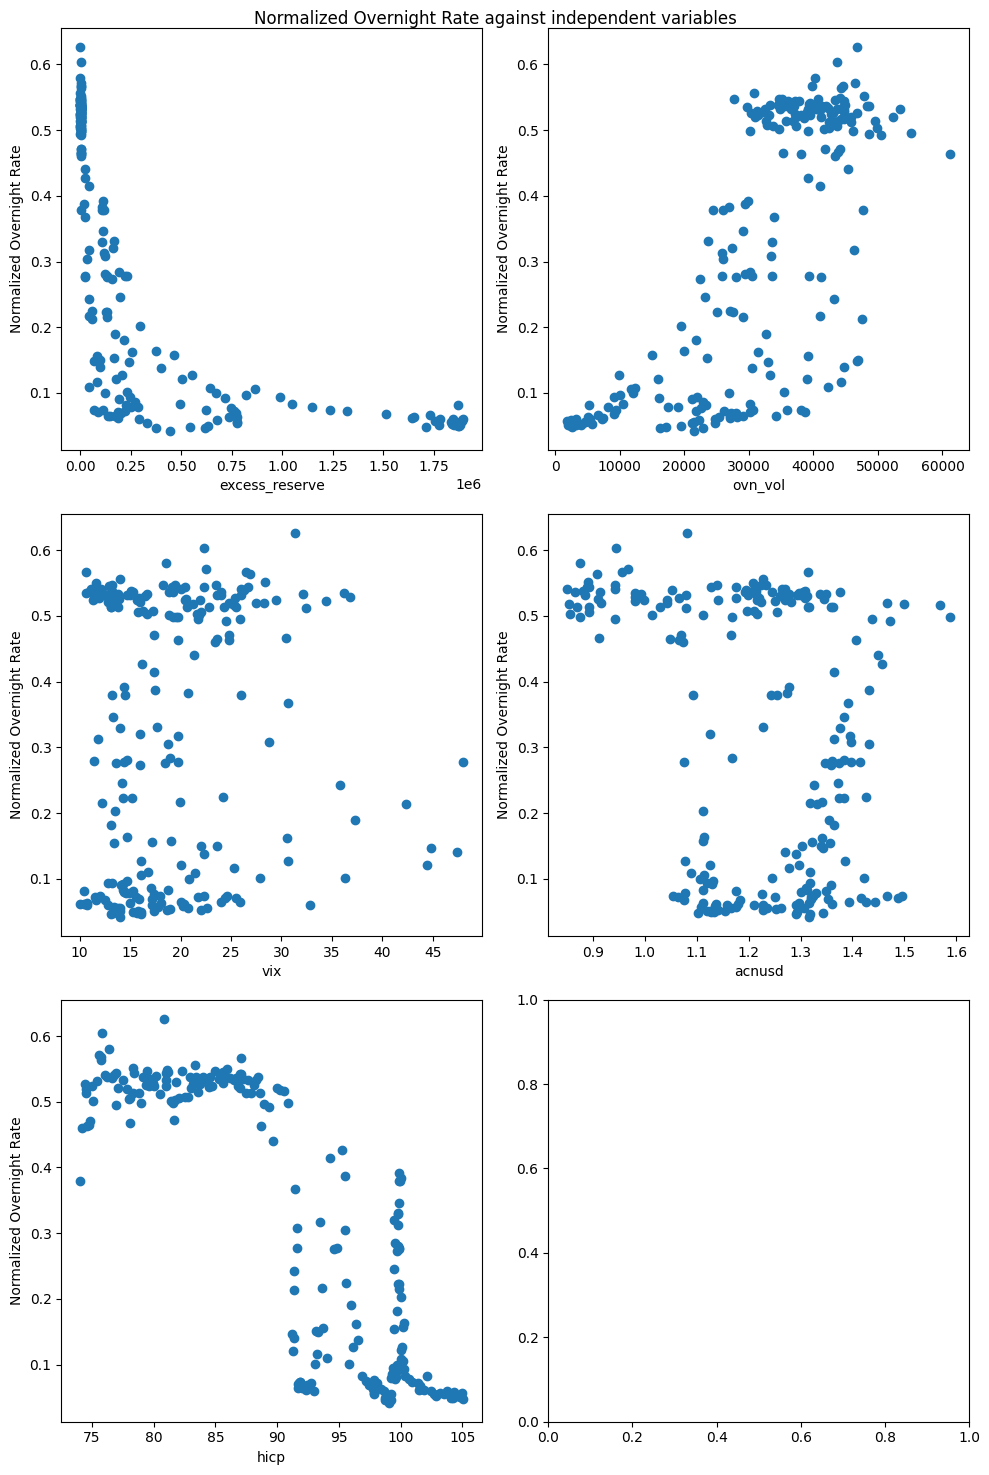

In [8]:
_ = obj.plot_x_y()

Running cross-validation for logistic curve


100%|██████████| 63/63 [00:33<00:00,  1.86 it/s]

Best combination for logistic: ['constant', 'excess_reserve', 'acnusd', 'hicp']
Training Metrics:
RMSE         0.060414
MAE          0.038481
MAPE        22.712094
R2           0.913046
MSLE         0.002389
MedianAE     0.018657
dtype: float64

Validation Metrics:
RMSE         0.060374
MAE          0.038917
MAPE        22.794759
R2           0.911130
MSLE         0.002426
MedianAE     0.018561
dtype: float64


Running cross-validation for redLogistic curve



100%|██████████| 63/63 [00:30<00:00,  2.05 it/s]

Best combination for redLogistic: ['constant', 'excess_reserve', 'ovn_vol', 'vix', 'acnusd']
Training Metrics:
RMSE         0.063137
MAE          0.039682
MAPE        22.817951
R2           0.904976
MSLE         0.002620
MedianAE     0.017523
dtype: float64

Validation Metrics:
RMSE         0.064065
MAE          0.041175
MAPE        23.472299
R2           0.899996
MSLE         0.002738
MedianAE     0.019233
dtype: float64


Running cross-validation for fixLogistic curve



100%|██████████| 63/63 [00:26<00:00,  2.41 it/s]

Best combination for fixLogistic: ['constant', 'excess_reserve', 'ovn_vol', 'vix', 'acnusd', 'hicp']
Training Metrics:
RMSE         0.062795
MAE          0.039547
MAPE        23.054533
R2           0.906008
MSLE         0.002590
MedianAE     0.017542
dtype: float64

Validation Metrics:
RMSE         0.064251
MAE          0.041331
MAPE        23.735832
R2           0.899325
MSLE         0.002755
MedianAE     0.019442
dtype: float64


Running cross-validation for doubleExp curve



100%|██████████| 63/63 [00:35<00:00,  1.80 it/s]

Best combination for doubleExp: ['excess_reserve', 'vix', 'acnusd']
Training Metrics:
RMSE         0.062837
MAE          0.039548
MAPE        23.060991
R2           0.905911
MSLE         0.002591
MedianAE     0.018639
dtype: float64

Validation Metrics:
RMSE         0.064206
MAE          0.040900
MAPE        23.412313
R2           0.898859
MSLE         0.002774
MedianAE     0.019478
dtype: float64


Running cross-validation for exponential curve



100%|██████████| 63/63 [00:28<00:00,  2.25 it/s]

Best combination for exponential: ['excess_reserve', 'ovn_vol', 'vix', 'acnusd']
Training Metrics:
RMSE         0.063478
MAE          0.040179
MAPE        23.662229
R2           0.903952
MSLE         0.002637
MedianAE     0.018368
dtype: float64

Validation Metrics:
RMSE         0.064188
MAE          0.041656
MAPE        24.201882
R2           0.899586
MSLE         0.002737
MedianAE     0.020173
dtype: float64


Running cross-validation for fixExponential curve



100%|██████████| 63/63 [00:19<00:00,  3.20 it/s]

Best combination for fixExponential: ['excess_reserve', 'vix', 'acnusd']
Training Metrics:
RMSE         0.071803
MAE          0.051557
MAPE        41.393507
R2           0.877161
MSLE         0.003620
MedianAE     0.039335
dtype: float64

Validation Metrics:
RMSE         0.071808
MAE          0.052355
MAPE        41.714298
R2           0.874818
MSLE         0.003662
MedianAE     0.041645
dtype: float64


Running cross-validation for arctan curve



100%|██████████| 63/63 [00:24<00:00,  2.61 it/s]

Best combination for arctan: ['constant', 'excess_reserve']
Training Metrics:
RMSE         0.064059
MAE          0.039080
MAPE        21.251274
R2           0.902153
MSLE         0.002693
MedianAE     0.018307
dtype: float64

Validation Metrics:
RMSE         0.063137
MAE          0.039037
MAPE        21.288657
R2           0.902816
MSLE         0.002659
MedianAE     0.018639
dtype: float64


Running cross-validation for linear curve



100%|██████████| 63/63 [00:11<00:00,  5.33 it/s]


Best combination for linear: ['constant', 'excess_reserve', 'ovn_vol', 'vix', 'hicp']
Training Metrics:
RMSE         0.096303
MAE          0.072149
MAPE        61.623869
R2           0.778901
MSLE              NaN
MedianAE     0.049719
dtype: float64

Validation Metrics:
RMSE         0.096340
MAE          0.074429
MAPE        63.733614
R2           0.774111
MSLE         0.003992
MedianAE     0.055945
dtype: float64


Best curve based on Validation RMSE: logistic curve


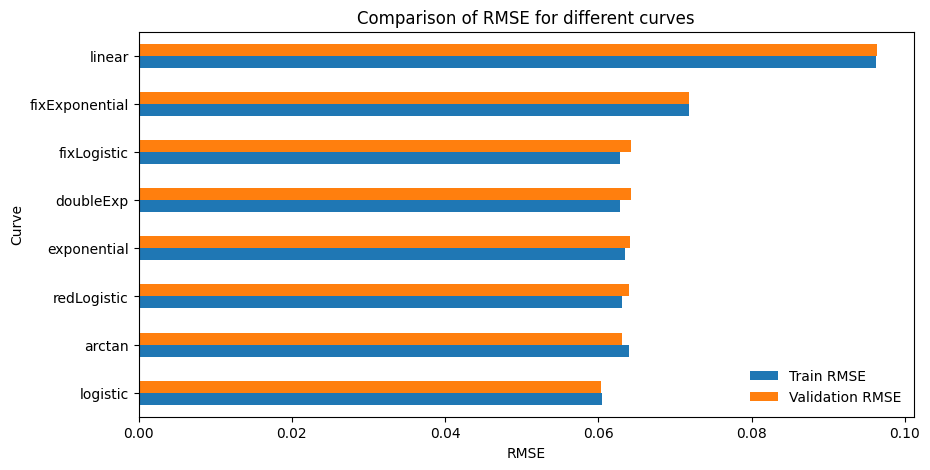

Curve,logistic,redLogistic,fixLogistic,doubleExp,exponential,fixExponential,arctan,linear
Best Combination,"[constant, excess_reserve, acnusd, hicp]","[constant, excess_reserve, ovn_vol, vix, acnusd]","[constant, excess_reserve, ovn_vol, vix, acnus...","[excess_reserve, vix, acnusd]","[excess_reserve, ovn_vol, vix, acnusd]","[excess_reserve, vix, acnusd]","[constant, excess_reserve]","[constant, excess_reserve, ovn_vol, vix, hicp]"
Train RMSE,0.060414,0.063137,0.062795,0.062837,0.063478,0.071803,0.064059,0.096303
Train MAE,0.038481,0.039682,0.039547,0.039548,0.040179,0.051557,0.03908,0.072149
Train MAPE,22.712094,22.817951,23.054533,23.060991,23.662229,41.393507,21.251274,61.623869
Train R2,0.913046,0.904976,0.906008,0.905911,0.903952,0.877161,0.902153,0.778901
Train MSLE,0.002389,0.00262,0.00259,0.002591,0.002637,0.00362,0.002693,NaN
Train MedianAE,0.018657,0.017523,0.017542,0.018639,0.018368,0.039335,0.018307,0.049719
Validation RMSE,0.060374,0.064065,0.064251,0.064206,0.064188,0.071808,0.063137,0.09634
Validation MAE,0.038917,0.041175,0.041331,0.0409,0.041656,0.052355,0.039037,0.074429
Validation MAPE,22.794759,23.472299,23.735832,23.412313,24.201882,41.714298,21.288657,63.733614


In [9]:
best_curve, cv_result = obj.variable_select(on='RMSE', verbose=True, plot=True)
cv_result.set_index('Curve').T

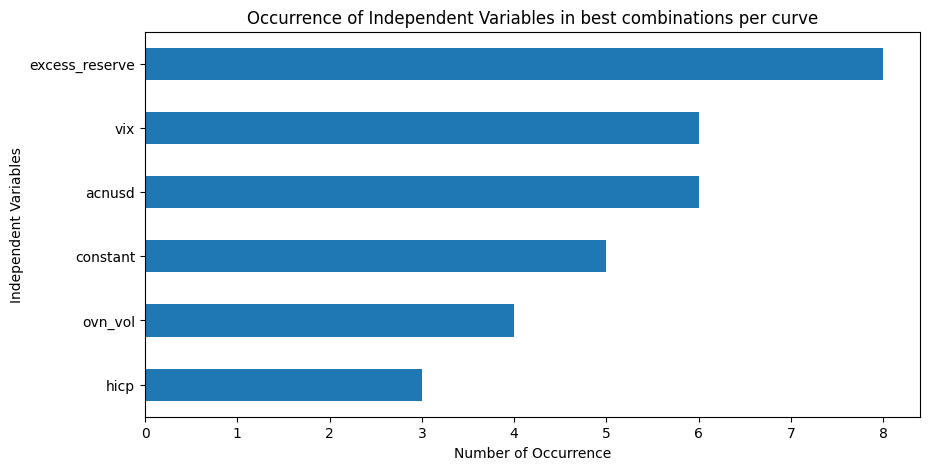

hicp              3
ovn_vol           4
constant          5
acnusd            6
vix               6
excess_reserve    8
dtype: int64

In [10]:
obj.indep_vars_occurence(normalize=False)

In [11]:
best_params = obj.fit_best_curves()

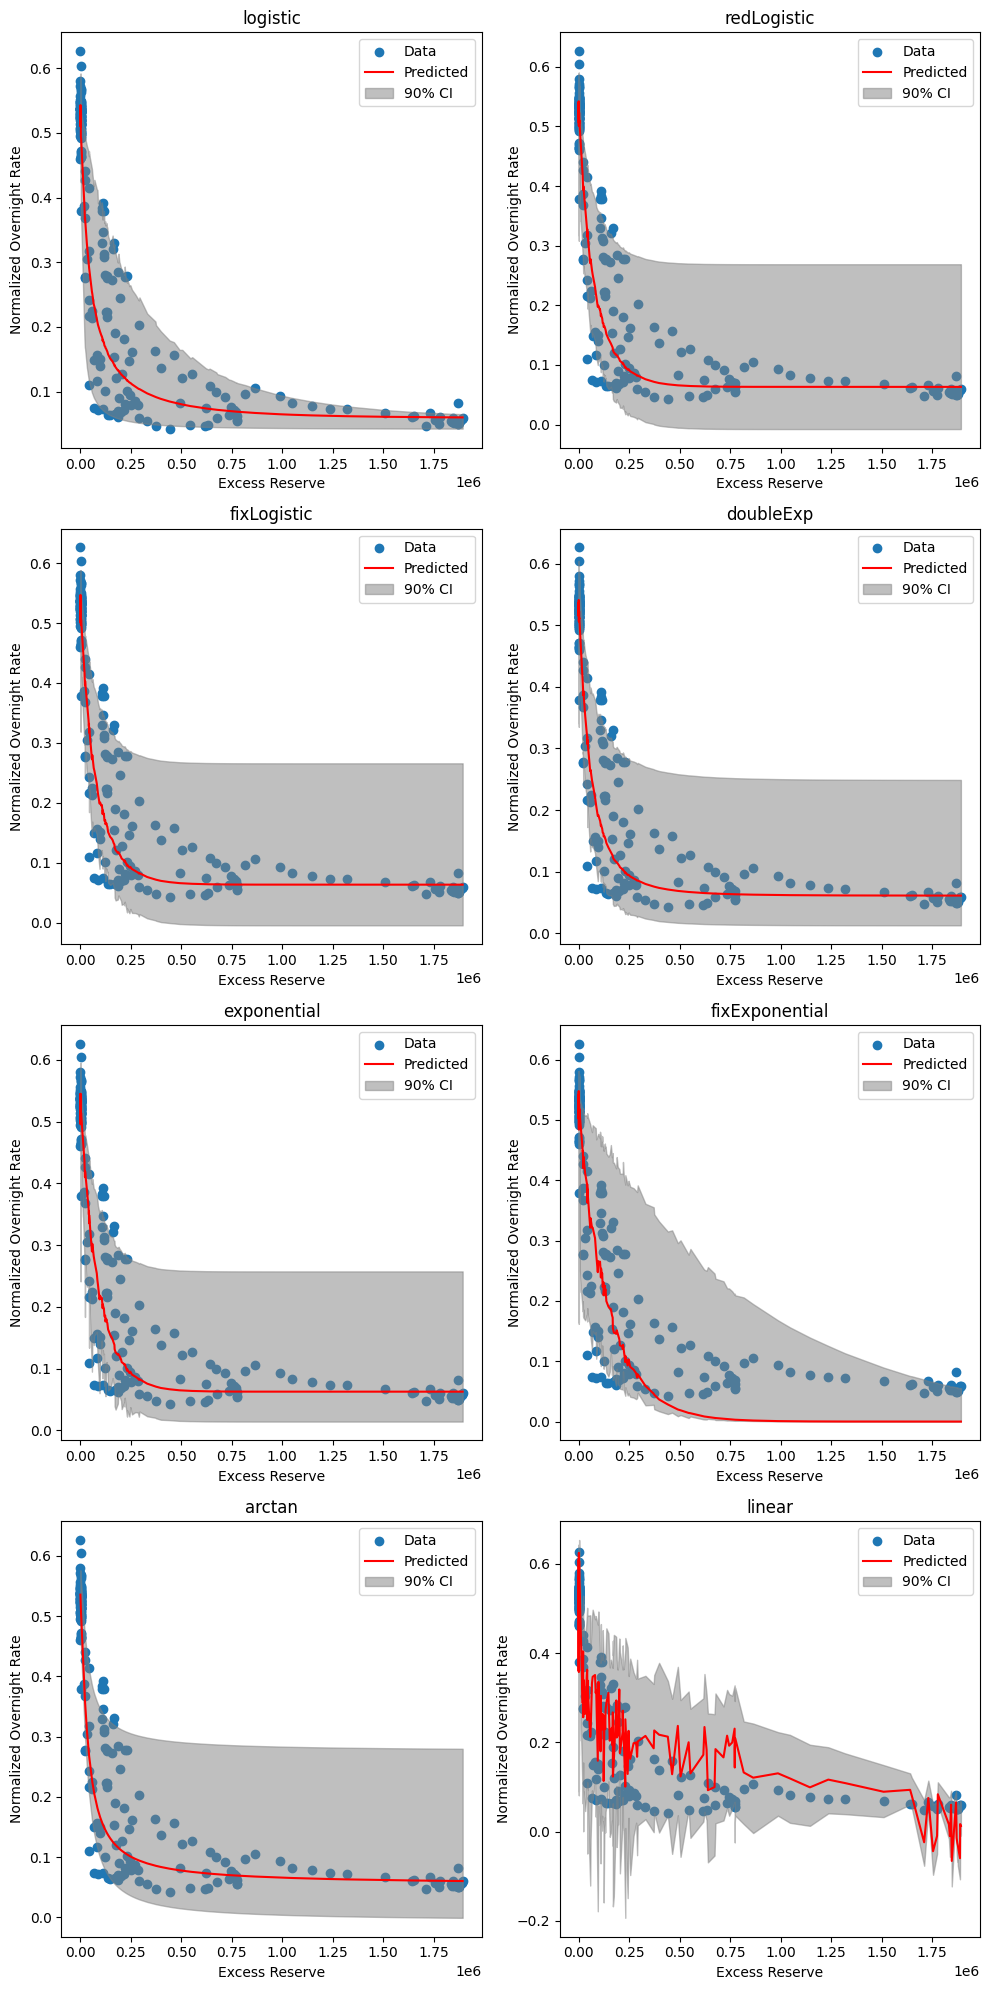

In [12]:
perf_metrics_df, predictions_df, param_df = obj.compare_best_curves(CI = True)

In [13]:
forecast_input = dat.tail(2).drop(columns=['Normalized'])
forecast_output = obj.predict_best_curve('exponential', X=forecast_input)
forecast_output

,excess_reserve,ovn_vol,vix,acnusd,ypred,ypred_upper,ypred_lower
228,0.927237,0.031745,0.468667,1.504435,0.062569,0.014113,0.257393
229,0.903961,0.042783,0.414104,1.495997,0.062569,0.014113,0.257393
